In [1]:
from vae_nocnn_model import VAE,CVAE
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

/home/tignjatov/anaconda3/envs/ml/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [3]:
CHANNELS_IMG = 1
IMG_SIZE = 64
BATCH_SIZE = 64
EPOCHS = 5

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [5]:
trainset = torchvision.datasets.MNIST(root='../data', 
                                      train=True,
                                      transform=transform,
                                      download= True)
testset = torchvision.datasets.MNIST(root='../data', 
                                      train=False,
                                      transform=transform,
                                      download= True)

In [6]:
train_dataloarder = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
model = CVAE(x_dim=IMG_SIZE*IMG_SIZE, h_dim1= 512, h_dim2=256, z_dim=20,device = device)

In [8]:
model.to(device)

CVAE(
  (fc1): Linear(in_features=4097, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=20, bias=True)
  (fc32): Linear(in_features=256, out_features=20, bias=True)
  (fc4): Linear(in_features=21, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=4096, bias=True)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [10]:
# def loss_function(recon_x, x, mu, log_var):
#     bce = nn.CrossEntropyLoss(reduction='sum')
#     BCE = bce(recon_x.flatten(1), x.flatten(1))
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     return BCE + KLD
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.flatten(1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [11]:
writer_real = SummaryWriter(f"logs/CVAE_MNIST/real")
writer_fake = SummaryWriter(f"logs/CVAE_MNIST/fake")
step = 0
train_losses = []
test_losses = []
for epoch in range(EPOCHS):
    train_epoch_loss = 0
    test_epoch_loss = 0
    for batch_idx,(img,lab) in enumerate(train_dataloarder):
        model.train()
        img = img.to(device)
        lab = lab.to(device)
        optimizer.zero_grad()
        recon_img, mu, log_var = model(img,lab)
        #print(mu)
        #print(log_var)
        
        loss = loss_function(recon_img, img, mu, log_var)
        #print(loss)
        #print(recon_img.shape)
        #print(loss.item())
        train_epoch_loss += loss.item() 
        loss.backward()
        optimizer.step()
    
        model.eval()
        if batch_idx % 100 == 0 and batch_idx > 0:
                print(
                    f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(train_dataloarder)} \
                      Loss : {train_epoch_loss:.4f}"
                )

                with torch.no_grad():
                    gen_img = model.sample(BATCH_SIZE,lab)
                    gen_img = gen_img.view(BATCH_SIZE,1,IMG_SIZE,IMG_SIZE)
                    # take out (up to) 32 examples
                    img_grid_real = torchvision.utils.make_grid(img[:32], normalize=True)
                    img_grid_fake = torchvision.utils.make_grid(gen_img[:32], normalize=True)

                    writer_real.add_image("Real", img_grid_real, global_step=step)
                    writer_fake.add_image("Fake", img_grid_fake, global_step=step)

                step += 1
    train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for img,lab in test_loader:
            img = img.to(device)
            lab = lab.to(device)
            recon_img, mu, log_var = model(img,lab)
            loss = loss_function(recon_img, img, mu, log_var)
            test_epoch_loss += loss.item()
    test_losses.append(test_epoch_loss)

/home/tignjatov/anaconda3/envs/ml/lib/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [0/5] Batch 100/938                       Loss : -1154819972.2148
Epoch [0/5] Batch 200/938                       Loss : -2508673057.2148
Epoch [0/5] Batch 300/938                       Loss : -3958333993.2148
Epoch [0/5] Batch 400/938                       Loss : -5339945587.2148
Epoch [0/5] Batch 500/938                       Loss : -6822095705.2148
Epoch [0/5] Batch 600/938                       Loss : -8461445927.2148
Epoch [0/5] Batch 700/938                       Loss : -10139487435.2148
Epoch [0/5] Batch 800/938                       Loss : -11913488538.2148
Epoch [0/5] Batch 900/938                       Loss : -13697101616.2148
Epoch [1/5] Batch 100/938                       Loss : -1829363810.0000
Epoch [1/5] Batch 200/938                       Loss : -3646422898.0000
Epoch [1/5] Batch 300/938                       Loss : -5469303418.0000
Epoch [1/5] Batch 400/938                       Loss : -7293582978.0000
Epoch [1/5] Batch 500/938                       Loss : -91465

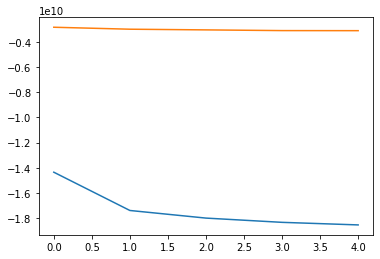

In [14]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.show()